# Housing Company Sales Prediction using Linear, Ridge and Lasso Regression

## Data Understanding and Exploration

In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import os

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Reading dataset
data=pd.read_csv("train.csv")

In [3]:
#Summary of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
data.shape

(1460, 81)

### Handling missing values

In [6]:
#Get columns with null values
data[data.columns[data.isna().sum()>0]].isna().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [7]:
#Drop all columns having more than 80% same values
cols_to_drop = []
for col in data.columns :
    max_pct = np.max(data[col].value_counts(normalize=True) * 100)
    if (max_pct > 80) :
        cols_to_drop.append(col)
        
data.drop(cols_to_drop, axis=1, inplace=True)
data.drop('Id', axis=1, inplace=True)
data.shape
print(cols_to_drop)

['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'BsmtFinSF2', 'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscFeature', 'MiscVal', 'SaleType', 'SaleCondition']


In [8]:
#Handling columns with faluty null value instead of real value as it should be as per the doc
#(like Alley NA means No Alley Access, not null(NaN))
data.loc[data['Alley'].isna(),'Alley']='No'
data.loc[data['BsmtQual'].isna(),'BsmtQual']='No'
data.loc[data['BsmtExposure'].isna(),'BsmtExposure']='No'
data.loc[data['BsmtFinType1'].isna(),'BsmtFinType1']='No'
data.loc[data['FireplaceQu'].isna(),'FireplaceQu']='No'
data.loc[data['GarageType'].isna(),'GarageType']='No'
data.loc[data['GarageFinish'].isna(),'GarageFinish']='No'
data.loc[data['PoolQC'].isna(),'PoolQC']='No'
data.loc[data['Fence'].isna(),'Fence']='No'

In [9]:
#Checking for remaining null values
data[data.columns[data.isna().sum()>0]].isna().sum()

LotFrontage    259
MasVnrType       8
MasVnrArea       8
GarageYrBlt     81
dtype: int64

In [10]:
#Getting mode for categorical values
MVTypeMod=data['MasVnrType'].mode()
GYrBltMod=data['GarageYrBlt'].mode()

In [11]:
#Assigning values to null value(as per the feature property)
data.loc[data['LotFrontage'].isna(),'LotFrontage']=data['LotFrontage'].quantile(0.5)
data.loc[data['MasVnrType'].isna(),'MasVnrType']=MVTypeMod[0]
data.loc[data['MasVnrArea'].isna(),'MasVnrArea']=data['MasVnrArea'].quantile(0.5)
data.loc[data['GarageYrBlt'].isna(),'GarageYrBlt']=GYrBltMod[0]
data[data.columns[data.isna().sum()>0]].isna().sum()

Series([], dtype: float64)

In [12]:
data.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,...,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,PoolQC,Fence,MoSold,YrSold,SalePrice
0,60,RL,65.0,8450,No,Reg,Inside,CollgCr,2Story,7,...,RFn,2,548,0,61,No,No,2,2008,208500
1,20,RL,80.0,9600,No,Reg,FR2,Veenker,1Story,6,...,RFn,2,460,298,0,No,No,5,2007,181500
2,60,RL,68.0,11250,No,IR1,Inside,CollgCr,2Story,7,...,RFn,2,608,0,42,No,No,9,2008,223500
3,70,RL,60.0,9550,No,IR1,Corner,Crawfor,2Story,7,...,Unf,3,642,0,35,No,No,2,2006,140000
4,60,RL,84.0,14260,No,IR1,FR2,NoRidge,2Story,8,...,RFn,3,836,192,84,No,No,12,2008,250000
5,50,RL,85.0,14115,No,IR1,Inside,Mitchel,1.5Fin,5,...,Unf,2,480,40,30,No,MnPrv,10,2009,143000
6,20,RL,75.0,10084,No,Reg,Inside,Somerst,1Story,8,...,RFn,2,636,255,57,No,No,8,2007,307000
7,60,RL,69.0,10382,No,IR1,Corner,NWAmes,2Story,7,...,RFn,2,484,235,204,No,No,11,2009,200000
8,50,RM,51.0,6120,No,Reg,Inside,OldTown,1.5Fin,7,...,Unf,2,468,90,0,No,No,4,2008,129900
9,190,RL,50.0,7420,No,Reg,Corner,BrkSide,1.5Unf,5,...,RFn,1,205,0,4,No,No,1,2008,118000


### Understanding the Data Dictionary

In [13]:
#Checking MSSubClass category values
data['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [14]:
#Checking OverallCond rank value (Ordinal value) being 10 highest and 1 lowest 
data['OverallCond'].value_counts()

5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

In [15]:
#Checking OverallQual rank value (Ordinal value) being 10 highest and 1 lowest
data['OverallQual'].value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

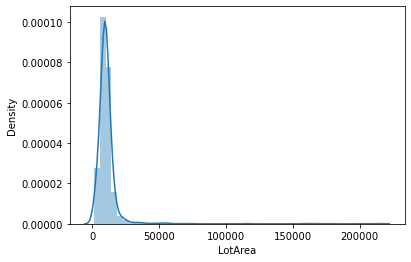

In [16]:
#LotArea: Lot size in sq. feet
sns.distplot(data['LotArea'])
plt.show()

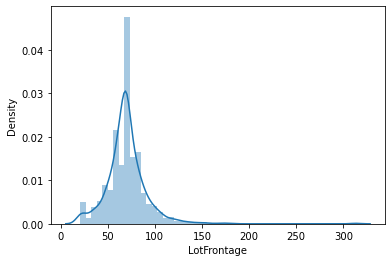

In [17]:
#LotFrontage: Linear feet of street connected to property
sns.distplot(data['LotFrontage'])
plt.show()

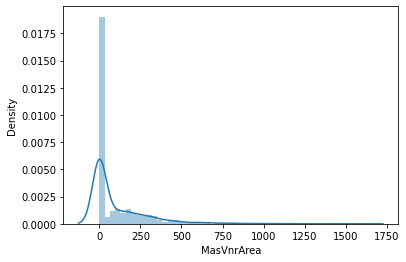

In [18]:
#MasVnrArea: Masonry veneer area in sq feet
sns.distplot(data['MasVnrArea'])
plt.show()

In [19]:
#Getting all numerical features
data_num=data.select_dtypes(include=['float64','int64'])
data_num.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,567.240411,...,6.517808,0.613014,1979.976027,1.767123,472.980137,94.244521,46.660274,6.321918,2007.815753,180921.195890
std,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,441.866955,...,1.625393,0.644666,24.749688,0.747315,213.804841,125.338794,66.256028,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,...,5.000000,0.000000,1962.000000,1.000000,334.500000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,477.500000,...,6.000000,1.000000,1984.500000,2.000000,480.000000,0.000000,25.000000,6.000000,2008.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,808.000000,...,7.000000,1.000000,2003.000000,2.000000,576.000000,168.000000,68.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,2336.000000,...,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,12.000000,2010.000000,755000.000000


In [20]:
#Removing categorical variables having numerical values
data_num=data_num.drop(['MSSubClass','OverallQual','OverallCond'],axis=1)
data_num.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
0,65.0,8450,2003,2003,196.0,706,150,856,856,854,...,8,0,2003.0,2,548,0,61,2,2008,208500
1,80.0,9600,1976,1976,0.0,978,284,1262,1262,0,...,6,1,1976.0,2,460,298,0,5,2007,181500
2,68.0,11250,2001,2002,162.0,486,434,920,920,866,...,6,1,2001.0,2,608,0,42,9,2008,223500
3,60.0,9550,1915,1970,0.0,216,540,756,961,756,...,7,1,1998.0,3,642,0,35,2,2006,140000
4,84.0,14260,2000,2000,350.0,655,490,1145,1145,1053,...,9,1,2000.0,3,836,192,84,12,2008,250000


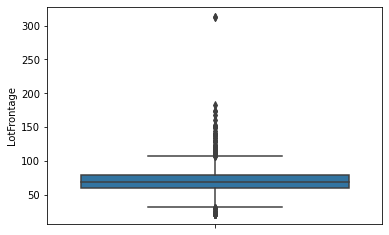

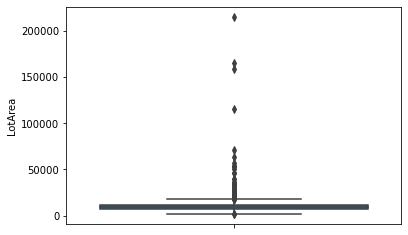

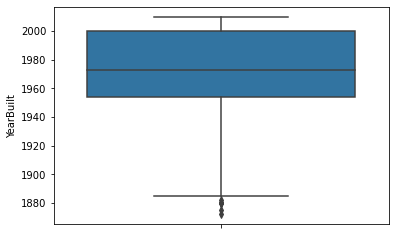

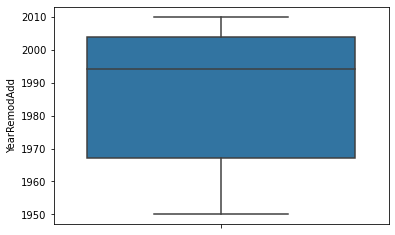

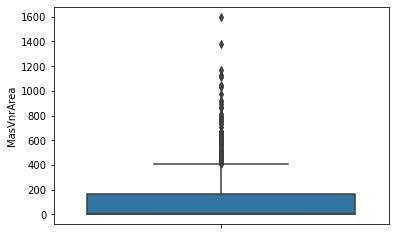

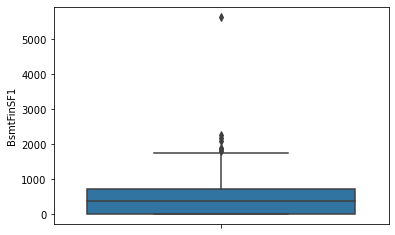

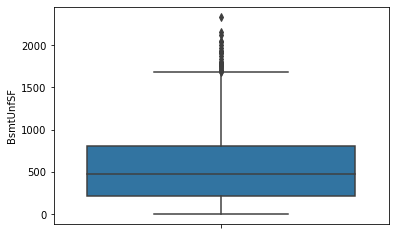

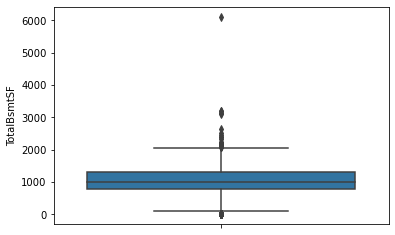

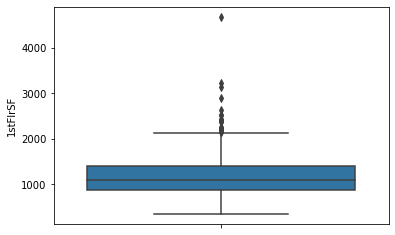

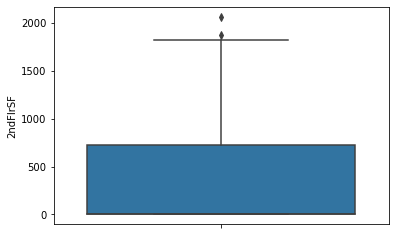

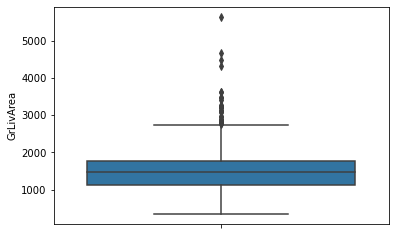

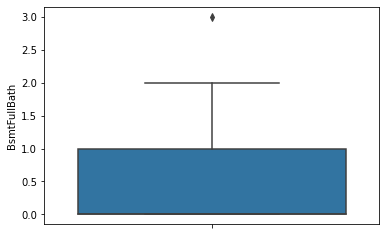

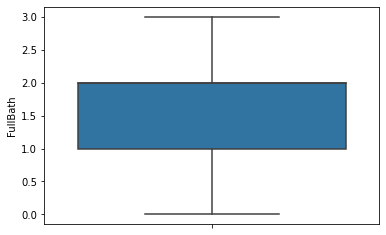

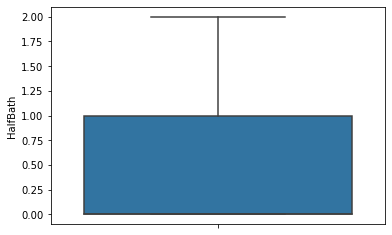

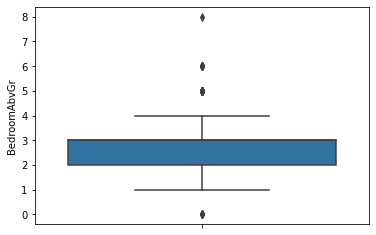

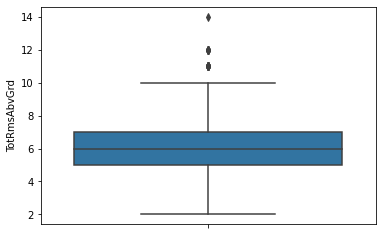

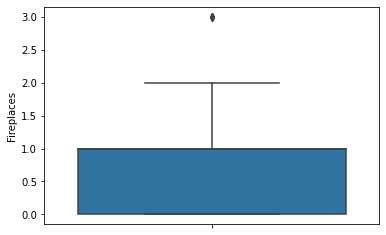

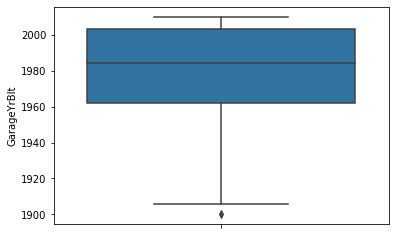

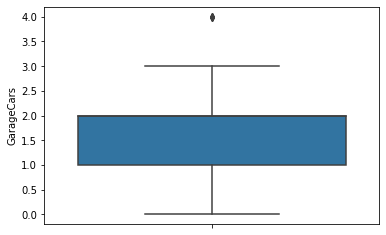

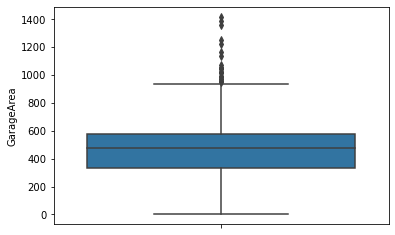

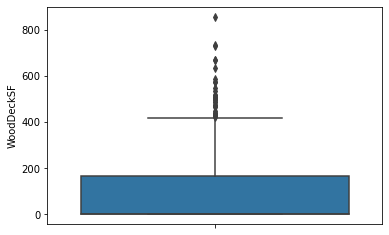

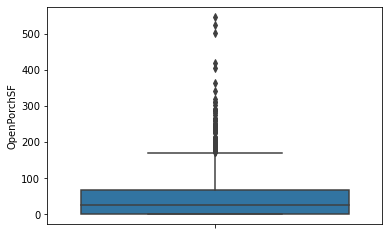

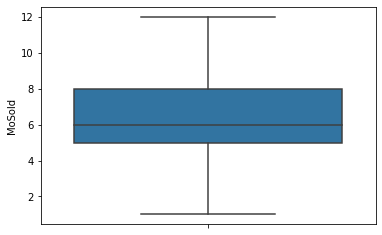

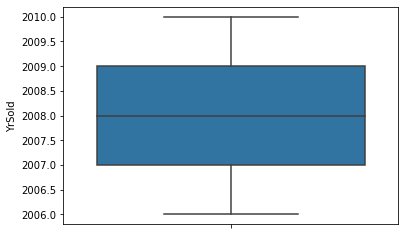

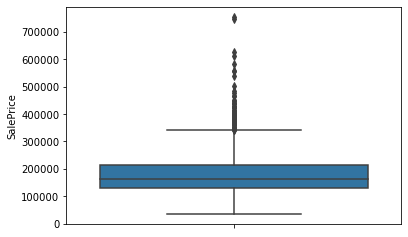

In [21]:
#Plotting all numerical values box plot
for col in data_num:
    plt.figure()
    sns.boxplot(y=data[col])
    plt.show()

In [22]:
#Removing outliers from all continuous variables
print(data.shape)   
for col in data_num:
    p25=data[col].quantile(0.25)
    p75=data[col].quantile(0.75)
    iqr=p75-p25
    ul=p75+1.5*iqr
    ll=p25-1.5*iqr
    data=data[(data[col]>=ll) & (data[col]<=ul)]
    
print(data.shape)

(1460, 50)
(957, 50)


In [23]:
data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,...,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,53.030303,66.885057,8958.393939,5.845350,5.648903,1968.425287,1983.188088,55.779519,396.826541,551.062696,...,6.128527,0.498433,1977.340648,1.623824,430.530825,76.640543,29.160920,6.268548,2007.801463,158510.386625
std,38.377285,13.499936,2679.438647,1.141235,1.120385,30.085859,21.131837,93.536114,368.364171,387.208287,...,1.259770,0.590411,25.663842,0.658527,180.439162,100.065692,38.742461,2.676408,1.328115,45776.395448
min,20.000000,32.000000,2268.000000,1.000000,1.000000,1880.000000,1950.000000,0.000000,0.000000,0.000000,...,3.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,35311.000000
25%,20.000000,60.000000,7332.000000,5.000000,5.000000,1949.000000,1963.000000,0.000000,0.000000,245.000000,...,5.000000,0.000000,1959.000000,1.000000,300.000000,0.000000,0.000000,4.000000,2007.000000,127500.000000
50%,50.000000,69.000000,8978.000000,6.000000,5.000000,1969.000000,1991.000000,0.000000,375.000000,485.000000,...,6.000000,0.000000,1979.000000,2.000000,442.000000,0.000000,0.000000,6.000000,2008.000000,152000.000000
75%,60.000000,75.000000,10500.000000,7.000000,6.000000,1999.000000,2003.000000,99.000000,662.000000,794.000000,...,7.000000,1.000000,2003.000000,2.000000,540.000000,144.000000,49.000000,8.000000,2009.000000,186500.000000
max,190.000000,107.000000,16770.000000,9.000000,9.000000,2009.000000,2010.000000,387.000000,1606.000000,1652.000000,...,10.000000,2.000000,2010.000000,3.000000,936.000000,394.000000,150.000000,12.000000,2010.000000,284000.000000


### Data Exploration

We have 25 numerical variable. Pairplot would take too much time to plot 25x25 graphs so we just check correlation with values and plot heatmap

In [24]:
#Correlation Matrix
corr=data_num.corr()
corr

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
LotFrontage,1.000000,0.304522,0.116685,0.083348,0.178469,0.214367,0.124098,0.363472,0.413773,0.072388,...,0.320518,0.233221,0.038892,0.269539,0.323511,0.075542,0.137014,0.010451,0.006380,0.334771
LotArea,0.304522,1.000000,0.014228,0.013788,0.103321,0.214103,-0.002618,0.260833,0.299475,0.050986,...,0.190015,0.271364,-0.042198,0.154871,0.180403,0.171698,0.084774,0.001205,-0.014261,0.263843
YearBuilt,0.116685,0.014228,1.000000,0.592855,0.311600,0.249503,0.149040,0.391452,0.281986,0.010308,...,0.095589,0.147716,0.700098,0.537850,0.478954,0.224880,0.188686,0.012398,-0.013618,0.522897
YearRemodAdd,0.083348,0.013788,0.592855,1.000000,0.176529,0.128451,0.181133,0.291066,0.240379,0.140024,...,0.191740,0.112581,0.571369,0.420622,0.371600,0.205726,0.226298,0.021490,0.035743,0.507101
MasVnrArea,0.178469,0.103321,0.311600,0.176529,1.000000,0.261256,0.113862,0.360067,0.339850,0.173800,...,0.279568,0.247015,0.209289,0.361945,0.370884,0.159991,0.122528,-0.006723,-0.008317,0.472614
BsmtFinSF1,0.214367,0.214103,0.249503,0.128451,0.261256,1.000000,-0.495251,0.522396,0.445863,-0.137079,...,0.044316,0.260011,0.119267,0.224054,0.296970,0.204306,0.111761,-0.015727,0.014359,0.386420
BsmtUnfSF,0.124098,-0.002618,0.149040,0.181133,0.113862,-0.495251,1.000000,0.415360,0.317987,0.004469,...,0.250647,0.051575,0.172350,0.214175,0.183303,-0.005316,0.129005,0.034888,-0.041258,0.214479
TotalBsmtSF,0.363472,0.260833,0.391452,0.291066,0.360067,0.522396,0.415360,1.000000,0.819530,-0.174512,...,0.285573,0.339519,0.262945,0.434585,0.486665,0.232019,0.247264,0.013196,-0.014969,0.613581
1stFlrSF,0.413773,0.299475,0.281986,0.240379,0.339850,0.445863,0.317987,0.819530,1.000000,-0.202646,...,0.409516,0.410531,0.182240,0.439317,0.489782,0.235459,0.211671,0.031372,-0.013604,0.605852
2ndFlrSF,0.072388,0.050986,0.010308,0.140024,0.173800,-0.137079,0.004469,-0.174512,-0.202646,1.000000,...,0.616423,0.194561,0.052291,0.183926,0.138347,0.092165,0.208026,0.035164,-0.028700,0.319334


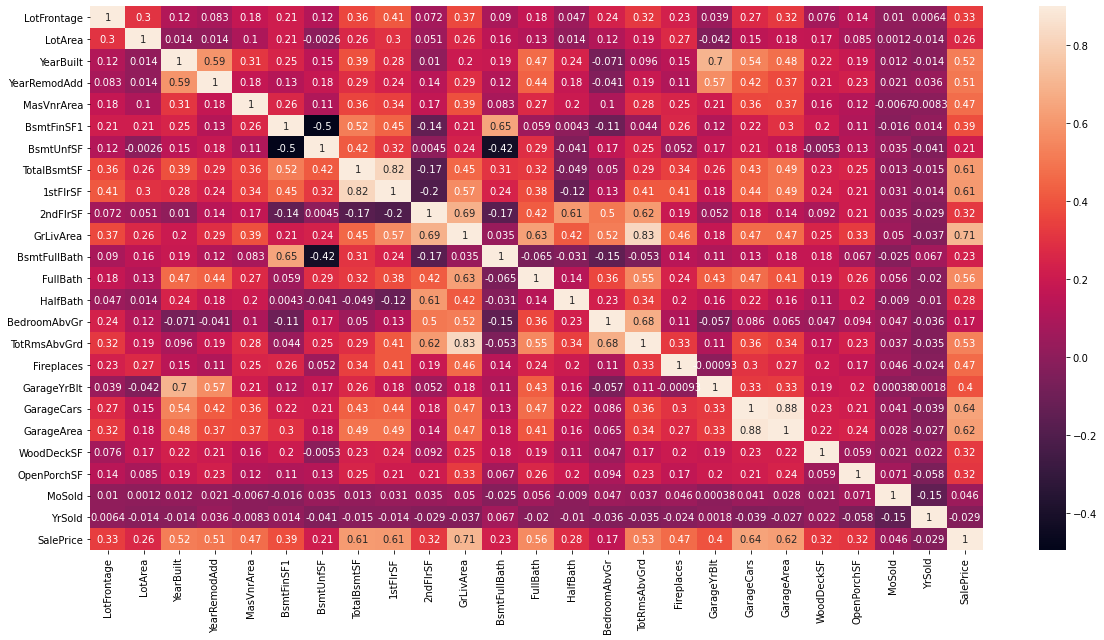

In [25]:
#Plotting heatmap of correlations
plt.figure(figsize=(20,10))

#heatmap
sns.heatmap(corr, vmax=0.9, annot=True)
plt.show()

The heatmap shows some insights:

Correlation of SalePrice with independent variables:
- Highly correlated with GrLivArea (0.71) also good correlation with YearBuilt, TotalBsmtSF, 1stFlrSF and TotRmsAbvGrd

Correlation of independent variables:
- Many independent variables have high correlation but GrLivArea::TotRmsAbvGrd and GarageCars::GarageArea has very high correlation

Hence, while building the model we'll have to pay attention to multicollinearity

## Data Cleaning

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 957 entries, 0 to 1458
Data columns (total 50 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSSubClass    957 non-null    int64  
 1   MSZoning      957 non-null    object 
 2   LotFrontage   957 non-null    float64
 3   LotArea       957 non-null    int64  
 4   Alley         957 non-null    object 
 5   LotShape      957 non-null    object 
 6   LotConfig     957 non-null    object 
 7   Neighborhood  957 non-null    object 
 8   HouseStyle    957 non-null    object 
 9   OverallQual   957 non-null    int64  
 10  OverallCond   957 non-null    int64  
 11  YearBuilt     957 non-null    int64  
 12  YearRemodAdd  957 non-null    int64  
 13  RoofStyle     957 non-null    object 
 14  Exterior1st   957 non-null    object 
 15  Exterior2nd   957 non-null    object 
 16  MasVnrType    957 non-null    object 
 17  MasVnrArea    957 non-null    float64
 18  ExterQual     957 non-null   

### Dummy Variable

In [27]:
#Converting Categorical numerical variables to object type
data['MSSubClass']=data['MSSubClass'].astype('object')
data['OverallQual']=data['OverallQual'].astype('object')
data['OverallCond']=data['OverallCond'].astype('object')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 957 entries, 0 to 1458
Data columns (total 50 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSSubClass    957 non-null    object 
 1   MSZoning      957 non-null    object 
 2   LotFrontage   957 non-null    float64
 3   LotArea       957 non-null    int64  
 4   Alley         957 non-null    object 
 5   LotShape      957 non-null    object 
 6   LotConfig     957 non-null    object 
 7   Neighborhood  957 non-null    object 
 8   HouseStyle    957 non-null    object 
 9   OverallQual   957 non-null    object 
 10  OverallCond   957 non-null    object 
 11  YearBuilt     957 non-null    int64  
 12  YearRemodAdd  957 non-null    int64  
 13  RoofStyle     957 non-null    object 
 14  Exterior1st   957 non-null    object 
 15  Exterior2nd   957 non-null    object 
 16  MasVnrType    957 non-null    object 
 17  MasVnrArea    957 non-null    float64
 18  ExterQual     957 non-null   

In [28]:
#Getting all the categorical variables
X=data
data_categorical=X.select_dtypes(include=['object'])
data_categorical.head()

,MSSubClass,MSZoning,Alley,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,RoofStyle,...,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,FireplaceQu,GarageType,GarageFinish,PoolQC,Fence
0,60,RL,No,Reg,Inside,CollgCr,2Story,7,5,Gable,...,Gd,No,GLQ,Ex,Gd,No,Attchd,RFn,No,No
1,20,RL,No,Reg,FR2,Veenker,1Story,6,8,Gable,...,Gd,Gd,ALQ,Ex,TA,TA,Attchd,RFn,No,No
2,60,RL,No,IR1,Inside,CollgCr,2Story,7,5,Gable,...,Gd,Mn,GLQ,Ex,Gd,TA,Attchd,RFn,No,No
3,70,RL,No,IR1,Corner,Crawfor,2Story,7,5,Gable,...,TA,No,ALQ,Gd,Gd,Gd,Detchd,Unf,No,No
4,60,RL,No,IR1,FR2,NoRidge,2Story,8,5,Gable,...,Gd,Av,GLQ,Ex,Gd,TA,Attchd,RFn,No,No


In [29]:
#Creating Dummy variables
data_dummies=pd.get_dummies(data_categorical, drop_first=True)
data_dummies

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,GarageType_No,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf,PoolQC_Gd,PoolQC_No,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_No
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1454,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1455,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1457,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [30]:
#Dropping categorical variables
X=X.drop(list(data_categorical.columns),axis=1)

In [31]:
#Adding Dummy variables
X=pd.concat([X,data_dummies],axis=1)

### Train Test Split and Scaling

Since the dataset is very small (957 rows), we are going for 80-20 split rather than 70-30, to provide sufficient training data to train the model

In [32]:
#Splitting training and test data
from sklearn.model_selection import train_test_split
train, test = train_test_split(X,train_size=0.8, random_state=100)

In [33]:
#Scaling the dataset using MinMaxScaling
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

cols=train.columns
train[cols]=scaler.fit_transform(train[cols])
train.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GarageType_No,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf,PoolQC_Gd,PoolQC_No,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_No
13,0.786667,0.583073,0.976744,0.950000,0.836066,0.000000,0.904358,0.788392,0.751067,0.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1254,0.373333,0.324292,0.953488,0.900000,0.251366,0.000000,0.451574,0.336155,0.229018,0.664196,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1246,0.440000,0.407330,0.968992,0.933333,0.000000,0.000000,0.457627,0.342201,0.226174,0.590808,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
546,0.506667,0.449892,0.333333,0.000000,0.000000,0.186800,0.463075,0.529021,0.339260,0.533729,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
288,0.493333,0.525141,0.674419,0.283333,0.084699,0.280199,0.261501,0.418380,0.328592,0.000000,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [34]:
y_train=train.pop('SalePrice')
X_train=train

In [35]:
print(X_train.shape)

(765, 175)


## Model Building and Evaluation

### Linear Regression

In [36]:
from sklearn.feature_selection import RFE
#Applying Simple Linear Regression
lm=LinearRegression()
lm.fit(X_train, y_train)

#Fetching top 40 features using RFE
rfe=RFE(lm,40)
rfe=rfe.fit(X_train,y_train)

We are using top 40 features to reduce the existing complexity of 175 features also not too less to give the room to Ridge and Lasso to handle the complexity (tried using 15 feature but Lasso and Ridge performing same as simple Linear regression)

In [37]:
#List of columns with rfe rank
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', False, 4),
 ('LotArea', True, 1),
 ('YearBuilt', True, 1),
 ('YearRemodAdd', False, 70),
 ('MasVnrArea', False, 94),
 ('BsmtFinSF1', False, 48),
 ('BsmtUnfSF', True, 1),
 ('TotalBsmtSF', True, 1),
 ('1stFlrSF', False, 88),
 ('2ndFlrSF', True, 1),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 50),
 ('FullBath', False, 19),
 ('HalfBath', False, 51),
 ('BedroomAbvGr', False, 93),
 ('TotRmsAbvGrd', False, 77),
 ('Fireplaces', False, 5),
 ('GarageYrBlt', False, 42),
 ('GarageCars', False, 30),
 ('GarageArea', True, 1),
 ('WoodDeckSF', False, 128),
 ('OpenPorchSF', False, 84),
 ('MoSold', False, 73),
 ('YrSold', False, 111),
 ('MSSubClass_30', False, 132),
 ('MSSubClass_40', False, 46),
 ('MSSubClass_45', False, 135),
 ('MSSubClass_50', False, 49),
 ('MSSubClass_60', False, 69),
 ('MSSubClass_70', False, 72),
 ('MSSubClass_75', False, 124),
 ('MSSubClass_80', True, 1),
 ('MSSubClass_85', False, 36),
 ('MSSubClass_90', True, 1),
 ('MSSubClass_120', False, 68),
 ('MSSubCla

In [38]:
#Top 40 columns
col=X_train.columns[rfe.support_]
print(col)

Index(['LotArea', 'YearBuilt', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF',
       'GrLivArea', 'GarageArea', 'MSSubClass_80', 'MSSubClass_90',
       'MSSubClass_160', 'MSSubClass_190', 'Neighborhood_BrkSide',
       'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_Somerst', 'HouseStyle_SLvl', 'OverallQual_7',
       'OverallQual_8', 'OverallQual_9', 'OverallCond_4', 'OverallCond_5',
       'OverallCond_6', 'OverallCond_7', 'OverallCond_8', 'OverallCond_9',
       'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'BsmtExposure_Gd',
       'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA',
       'GarageType_Attchd', 'GarageType_BuiltIn', 'GarageType_CarPort',
       'GarageType_Detchd', 'GarageType_No', 'GarageFinish_No', 'PoolQC_Gd',
       'PoolQC_No'],
      dtype='object')


In [39]:
#Fitting model with 40 selected features
X_train=X_train[col]

lmrfe=LinearRegression()
lmrfe.fit(X_train, y_train)

X_train.shape

(765, 40)

In [40]:
print(lmrfe.intercept_)
print(lmrfe.coef_)

-0.07727805098310542
[ 0.0652948   0.28928266 -0.07496882  0.23031561  0.04964407  0.36113382
  0.07134341 -0.04651551 -0.07363826 -0.11079213 -0.03662928  0.04808326
  0.13120444  0.06739197  0.06914242  0.05809348  0.05478501  0.05239186
  0.11752773  0.14893943  0.05843905  0.09856184  0.1126688   0.15148936
  0.15856391  0.17116104  0.04440918 -0.0322688   0.05129657 -0.12704848
 -0.09364549 -0.11678216  0.0754614   0.07537453  0.04266658  0.06367233
  0.03148754  0.03148754  0.04882423 -0.04882423]


In [41]:
from sklearn.metrics import r2_score, mean_squared_error

In [42]:
#Transforming test dataset
test[cols]=scaler.transform(test[cols])

#Splitting dependent and independent features
y_test=test.pop('SalePrice')
test=test[col]
X_test=test

In [43]:
y_pred_train=lmrfe.predict(X_train)
y_pred_test=lmrfe.predict(X_test)

metric=[]
#Calculating r2 score for training dataset
r2_train_lr=r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

#Calculating r2 score for testing dataset
r2_test_lr=r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

#Calculating rss for training dataset
rss1_lr= np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

#Calculating rss for test dataset
rss2_lr=np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

#Calculating mean squared error for training dataset
mse_train_lr=mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr)

#Calculating mean squared error for test dataset
mse_test_lr=mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr)

0.9028880905754555
0.8942249420091667
2.531568206855635
0.6682112096453513
0.0033092394860857973
0.0034802667169028714


## Ridge Regression

In [44]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [45]:
print(model_cv.best_params_)

{'alpha': 0.05}


In [46]:
#Fitting Ridge model for alpha = 0.05 and printing coefficients which have been penalised
alpha = model_cv.best_params_.get('alpha')
print(alpha)
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.intercept_)
print(ridge.coef_)

0.05
-0.07369354961013735
[ 0.06553897  0.28787429 -0.07483007  0.23153956  0.05161193  0.35711161
  0.07179389 -0.04456419 -0.0725388  -0.11044688 -0.03619248  0.04805941
  0.13090463  0.06698156  0.06931289  0.05787202  0.05321458  0.05256641
  0.11776116  0.14263557  0.05566541  0.09602551  0.11003277  0.14874934
  0.15564719  0.16748587  0.04423585 -0.03084984  0.05114792 -0.12684129
 -0.09304125 -0.1164939   0.0741408   0.07390852  0.04043139  0.06189592
  0.03047917  0.03047917  0.04747287 -0.04747287]


In [47]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9028773668132251
0.8943148789155947
2.53184775995763
0.6676430525563598
0.0033096049149772943
0.003477307565397707


## Lasso

In [48]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [49]:
print(model_cv.best_params_)

{'alpha': 0.0001}


In [50]:
#Fitting Ridge model for alpha = 0.0001 and printing coefficients which have been penalised

alpha = model_cv.best_params_.get('alpha')

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [51]:
print(lasso.intercept_)
lasso.coef_

-0.06050009875496748


array([ 6.58758925e-02,  2.90440798e-01, -7.34087013e-02,  2.22068079e-01,
        4.63937146e-02,  3.62234679e-01,  6.43879392e-02, -0.00000000e+00,
       -5.51334742e-02, -1.05740214e-01, -2.38720633e-02,  4.78133458e-02,
        1.26412280e-01,  5.61980224e-02,  6.79079106e-02,  5.39092386e-02,
        9.64759806e-03,  5.36917173e-02,  1.20741952e-01,  8.54402864e-02,
        2.14745266e-02,  6.39084683e-02,  7.93995122e-02,  1.17224392e-01,
        1.23047510e-01,  1.29573329e-01,  4.08177816e-02, -0.00000000e+00,
        4.59974221e-02, -1.20140049e-01, -8.27507262e-02, -1.08304741e-01,
        4.14249455e-02,  3.80223554e-02,  0.00000000e+00,  2.74171197e-02,
        1.65080951e-02,  0.00000000e+00,  1.81035153e-02, -1.00050858e-15])

In [52]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9007862047457788
0.8950903595225047
2.586361356041774
0.662744120386124
0.0033808645177016653
0.003451792293677729


In [53]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.902888,0.902877,0.900786
1,R2 Score (Test),0.894225,0.894315,0.895090
2,RSS (Train),2.531568,2.531848,2.586361
3,RSS (Test),0.668211,0.667643,0.662744
4,MSE (Train),0.003309,0.057529,0.058145
5,MSE (Test),0.003480,0.058969,0.058752


## Lets observe the changes in the coefficients after regularization

In [54]:
betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns
betas['Linear'] = lmrfe.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

#betas["LinearEq"] = "+" + betas["Linear"].round(decimals=4).astype(str) + "*" + betas.rows
#betas["RidgeEq"] = "+" + betas["Ridge"].round(decimals=4).astype(str) + "*" + betas.rows
#betas["LassoEq"] = "+" + betas["Lasso"].round(decimals=4).astype(str) + "*" + betas.rows

#print(betas["LinearEq"].to_string(index=False).replace("+-","-"))
#print(betas["RidgeEq"].to_string(index=False).replace("+-","-"))
#print(betas["LassoEq"].to_string(index=False).replace("+-","-"))

In [64]:
pd.set_option('display.max_rows', None)
#betas.sort_values('Lasso',ascending=False)
betas.reindex(betas.Lasso.abs().sort_values(ascending=False).index)

,Linear,Ridge,Lasso
GrLivArea,0.361134,0.357112,3.622347e-01
YearBuilt,0.289283,0.287874,2.904408e-01
TotalBsmtSF,0.230316,0.231540,2.220681e-01
OverallCond_9,0.171161,0.167486,1.295733e-01
Neighborhood_Crawfor,0.131204,0.130905,1.264123e-01
OverallCond_8,0.158564,0.155647,1.230475e-01
OverallQual_8,0.117528,0.117761,1.207420e-01
KitchenQual_Fa,-0.127048,-0.126841,-1.201400e-01
OverallCond_7,0.151489,0.148749,1.172244e-01
KitchenQual_TA,-0.116782,-0.116494,-1.083047e-01


We can conclude that ridge decreases the coefficient of every feature and lasso decreases them much more significantly (some zero (like GarageFinish_No, Exterior1st_CBlock) and some almost zero (like PoolQA_No which is as good as zero))

Linear Eq:
- -0.07727805098310542 + 0.0653 x LotArea + 0.2893 x YearBuilt - 0.075 x BsmtUnfSF + 0.2303 x TotalBsmtSF + 0.0496 x 2ndFlrSF + 0.3611 x GrLivArea + 0.0713 x GarageArea - 0.0465 x MSSubClass_80 - 0.0736 x MSSubClass_90 - 0.1108 x MSSubClass_160 - 0.0366 x MSSubClass_190 + 0.0481 x Neighborhood_BrkSide + 0.1312 x Neighborhood_Crawfor + 0.0674 x Neighborhood_NoRidge + 0.0691 x Neighborhood_NridgHt + 0.0581 x Neighborhood_Somerst + 0.0548 x HouseStyle_SLvl + 0.0524 x OverallQual_7 + 0.1175 x OverallQual_8 + 0.1489 x OverallQual_9 + 0.0584 x OverallCond_4 + 0.0986 x OverallCond_5 + 0.1127 x OverallCond_6 + 0.1515 x OverallCond_7 + 0.1586 x OverallCond_8 + 0.1712 x OverallCond_9 + 0.0444 x Exterior1st_BrkFace - 0.0323 x Exterior1st_CBlock + 0.0513 x BsmtExposure_Gd - 0.127 x KitchenQual_Fa - 0.0936 x KitchenQual_Gd - 0.1168 x KitchenQual_TA + 0.0755 x GarageType_Attchd + 0.0754 x GarageType_BuiltIn + 0.0427 x GarageType_CarPort + 0.0637 x GarageType_Detchd + 0.0315 x GarageType_No + 0.0315 x GarageFinish_No + 0.0488 x PoolQC_Gd - 0.0488 x PoolQC_No

Ridge Eq:
- -0.07369354961013735 + 0.0655 x LotArea + 0.2879 x YearBuilt - 0.0748 x BsmtUnfSF + 0.2315 x TotalBsmtSF + 0.0516 x 2ndFlrSF + 0.3571 x GrLivArea + 0.0718 x GarageArea - 0.0446 x MSSubClass_80 - 0.0725 x MSSubClass_90 - 0.1104 x MSSubClass_160 - 0.0362 x MSSubClass_190 + 0.0481 x Neighborhood_BrkSide + 0.1309 x Neighborhood_Crawfor + 0.067 x Neighborhood_NoRidge + 0.0693 x Neighborhood_NridgHt + 0.0579 x Neighborhood_Somerst + 0.0532 x HouseStyle_SLvl + 0.0526 x OverallQual_7 + 0.1178 x OverallQual_8 + 0.1426 x OverallQual_9 + 0.0557 x OverallCond_4 + 0.096 x OverallCond_5 + 0.11 x OverallCond_6 + 0.1487 x OverallCond_7 + 0.1556 x OverallCond_8 + 0.1675 x OverallCond_9 + 0.0442 x Exterior1st_BrkFace - 0.0308 x Exterior1st_CBlock + 0.0511 x BsmtExposure_Gd - 0.1268 x KitchenQual_Fa - 0.093 x KitchenQual_Gd - 0.1165 x KitchenQual_TA + 0.0741 x GarageType_Attchd + 0.0739 x GarageType_BuiltIn + 0.0404 x GarageType_CarPort + 0.0619 x GarageType_Detchd + 0.0305 x GarageType_No + 0.0305 x GarageFinish_No + 0.0475 x PoolQC_Gd - 0.0475 x PoolQC_No

Lasso Eq:

  - -0.06050009875496748 + 0.0659 x LotArea + 0.2904 x YearBuilt - 0.0734 x BsmtUnfSF + 0.2221 x TotalBsmtSF + 0.0464 x 2ndFlrSF + 0.3622 x GrLivArea + 0.0644 x GarageArea - 0.0 x MSSubClass_80 - 0.0551 x MSSubClass_90 - 0.1057 x MSSubClass_160 - 0.0239 x MSSubClass_190 + 0.0478 x Neighborhood_BrkSide + 0.1264 x Neighborhood_Crawfor + 0.0562 x Neighborhood_NoRidge + 0.0679 x Neighborhood_NridgHt + 0.0539 x Neighborhood_Somerst + 0.0096 x HouseStyle_SLvl + 0.0537 x OverallQual_7 + 0.1207 x OverallQual_8 + 0.0854 x OverallQual_9 + 0.0215 x OverallCond_4 + 0.0639 x OverallCond_5 + 0.0794 x OverallCond_6 + 0.1172 x OverallCond_7 + 0.123 x OverallCond_8 + 0.1296 x OverallCond_9 + 0.0408 x Exterior1st_BrkFace - 0.0 x Exterior1st_CBlock + 0.046 x BsmtExposure_Gd - 0.1201 x KitchenQual_Fa - 0.0828 x KitchenQual_Gd - 0.1083 x KitchenQual_TA + 0.0414 x GarageType_Attchd + 0.038 x GarageType_BuiltIn + 0.0 x GarageType_CarPort + 0.0274 x GarageType_Detchd + 0.0165 x GarageType_No + 0.0 x GarageFinish_No + 0.0181 x PoolQC_Gd - 0.0 x PoolQC_No

Lasso Eq wiuth 15 features (consider only 15 features with RFE. just to mention):
- 0.05282996292351311 + 0.3201 x YearBuilt + 0.1435 x TotalBsmtSF + 0.461 x GrLivArea + 0.1081 x GarageArea - 0.0807 x MSSubClass_90 - 0.1044 x MSSubClass_160 + 0.1557 x Neighborhood_Crawfor + 0.0849 x OverallQual_8 + 0.1089 x OverallQual_9 + 0.039 x OverallCond_8 + 0.0535 x OverallCond_9 - 0.14 x KitchenQual_Fa - 0.0834 x KitchenQual_Gd - 0.1222 x KitchenQual_TA + 0.0311 x PoolQC_Gd

Entire modeling not present for 15 features as all 3 Linear, with Ridge and Lasso returned almost same coef